In [1]:
import keras
import os
os.environ['KERAS_BACKEND']='tensorflow'
import h5py
import cv2
import matplotlib.pyplot as plt
import numpy as np
from os import walk
import random

np.random.seed(1337)  # for reproducibility

def setGPU():
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"
    import tensorflow as tf
    from keras.backend.tensorflow_backend import set_session
    config = tf.ConfigProto()
    #config.gpu_options.per_process_gpu_memory_fraction = 0.5
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))
setGPU()

print('libs loaded')

Using TensorFlow backend.


libs loaded


In [2]:
# parameters
data_path = '../data/seg_data/{}/'
size = 128

def load_filenames(path):
    filenames = []
    for (dirpath, dirnames, filenames) in walk(data_path.format('x')):
        filenames.extend(filenames)
        break
    for f in filenames:
        if not '.npy' in f:
            del f
    return filenames
    
filenames = load_filenames(data_path)
print(filenames)

['case1_label9.npy', 'case10_label11.npy', 'case6_label11.npy', 'case8_label11.npy', 'case10_label6.npy', 'case9_label19.npy', 'case2_label13.npy', 'case1_label6.npy', 'case9_label7.npy', 'case5_label3.npy', 'case6_label15.npy', 'case1_label4.npy', 'case6_label8.npy', 'case10_label4.npy', 'case9_label13.npy', 'case3_label6.npy', 'case2_label5.npy', 'case9_label12.npy', 'case6_label9.npy', 'case1_label19.npy', 'case3_label2.npy', 'case9_label17.npy', 'case10_label2.npy', 'case9_label10.npy', 'case8_label12.npy', 'case8_label4.npy', 'case4_label14.npy', 'case9_label5.npy', 'case4_label6.npy', 'case8_label5.npy', 'case5_label8.npy', 'case4_label3.npy', 'case8_label9.npy', 'case8_label18.npy', 'case8_label15.npy', 'case8_label10.npy', 'case9_label8.npy', 'case4_label11.npy', 'case5_label17.npy', 'case4_label12.npy', 'case3_label16.npy', 'case2_label8.npy', 'case2_label7.npy', 'case8_label19.npy', 'case3_label7.npy', 'case8_label8.npy', 'case4_label19.npy', 'case3_label15.npy', 'case6_label

In [3]:

def model():
    from keras.models import Model
    from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Concatenate, BatchNormalization, Activation
    
    def conv(input_tensor, depth):
        conv_tensor = Conv3D(depth, 3, padding = 'same', kernel_initializer = 'he_normal')(input_tensor)
        #bn = BatchNormalization()(conv_tensor) # use_bias=False
        output_tensor = Activation('relu')(conv_tensor)
        return output_tensor
    
    def pool(input_tensor):
        output_tensor = MaxPooling3D(pool_size=(2, 2, 2))(input_tensor)
        return output_tensor
    
    def up(input_tensor):
        output_tensor = UpSampling3D(size=(2, 2, 2))(input_tensor)
        return output_tensor
    
    def skip(input_tensor1, input_tensor2):
        output_tensor = Concatenate(axis=-1)([input_tensor1, input_tensor2])
        return output_tensor
    
    input_img = Input(shape=(size, size, size, 1))
    
    conv1 = conv(input_img, 32)
    conv2 = conv(conv1, 64)
    
    pool1 = pool(conv2)
    
    conv3 = conv(pool1, 64)
    conv4 = conv(conv3, 128)
    
    pool2 = pool(conv4)
    
    conv5 = conv(pool2, 128)
    conv6 = conv(conv5, 256)
    
    pool3 = pool(conv6)
    
    conv7 = conv(pool3, 256)
    conv8 = conv(conv7, 512)   

    up1 = up(conv8)
    
    skip1 = skip(conv6, up1)
    
    conv9 = conv(skip1, 256)
    conv10 = conv(conv9, 256)
    
    up2   = up(conv10)
    
    skip2 = skip(conv4, up2)
    
    conv11 = conv(skip2, 128)
    conv12 = conv(conv11, 128)
    
    up3   = up(conv12)
    
    skip3 = skip(conv2, up3)
    
    conv13 = conv(skip3, 64)
    conv14 = conv(conv13, 64)    
   
    conv15 = conv(conv14, 1)

    output_img = conv15

    # model
    model = Model(inputs=input_img, outputs=output_img)
    print (model.output_shape)

    # optimizer
    opt = keras.optimizers.Adam(lr=1e-5)

    model.compile(optimizer=opt,
                  loss='mse',
                  metrics=['accuracy'])
    
    model.summary()
    
    return model

model = model()

(None, 128, 128, 128, 1)
Instructions for updating:
keep_dims is deprecated, use keepdims instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 128 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 128, 128, 128 896         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 128 0           conv3d_1[0][0]                   
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 128, 128, 128 55360       activation_1[0][0]               
___________

In [9]:
def generator(batch_size):
    while 1:
        shape = (batch_size, size, size, size, 1)
        
        x_out = np.zeros(shape)
        y_out = np.zeros(shape)
        
        for i in range(batch_size):
            filename = random.choice(filenames)
            #filename = filenames[0]
            x = np.load(data_path.format('x') + filename)
            y = np.load(data_path.format('y') + filename)
            x = np.reshape(x, (size, size, size, -1))
            y = np.reshape(y, (size, size, size, -1))
            x_out[i] = x
            y_out[i] = y
            
        yield (x_out, y_out)

In [14]:
model.fit_generator(generator(1), steps_per_epoch=10, epochs=1000)

Epoch 1/1000
10/10 [==============================] - 19s 2s/step - loss: 0.0132 - acc: 0.9820
Epoch 2/1000
10/10 [==============================] - 19s 2s/step - loss: 0.0106 - acc: 0.9857
Epoch 3/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0103 - acc: 0.9863
Epoch 4/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0097 - acc: 0.9872
Epoch 5/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0120 - acc: 0.9823
Epoch 6/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0105 - acc: 0.9850
Epoch 7/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0102 - acc: 0.9846
Epoch 8/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0117 - acc: 0.9830
Epoch 9/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0102 - acc: 0.9840
Epoch 10/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0120 - acc: 0.9818
Epoch 11/1000
10/10 [============================

10/10 [==============================] - 20s 2s/step - loss: 0.0046 - acc: 0.9936
Epoch 176/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0034 - acc: 0.9955
Epoch 177/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0043 - acc: 0.9943
Epoch 178/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0048 - acc: 0.9933
Epoch 179/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0047 - acc: 0.9936
Epoch 180/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0041 - acc: 0.9947
Epoch 181/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0041 - acc: 0.9948
Epoch 182/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0040 - acc: 0.9946
Epoch 183/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0047 - acc: 0.9936
Epoch 184/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0037 - acc: 0.9951
Epoch 185/1000
10/10 [=======================

10/10 [==============================] - 20s 2s/step - loss: 0.0030 - acc: 0.9961
Epoch 344/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0025 - acc: 0.9969
Epoch 345/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0033 - acc: 0.9957
Epoch 346/1000
 6/10 [=================>............] - ETA: 7s - loss: 0.0026 - acc: 0.9965

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10/10 [==============================] - 20s 2s/step - loss: 0.0021 - acc: 0.9973
Epoch 596/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0016 - acc: 0.9980
Epoch 597/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0019 - acc: 0.9977
Epoch 598/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0017 - acc: 0.9980
Epoch 599/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0012 - acc: 0.9986
Epoch 600/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0013 - acc: 0.9983
Epoch 601/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0014 - acc: 0.9983
Epoch 602/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0011 - acc: 0.9987
Epoch 603/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0015 - acc: 0.9982
Epoch 604/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0011 - acc: 0.9987
Epoch 605/1000
10/10 [=======================

10/10 [==============================] - 20s 2s/step - loss: 0.0011 - acc: 0.9986
Epoch 773/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0011 - acc: 0.9987
Epoch 774/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0016 - acc: 0.9980
Epoch 775/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0014 - acc: 0.9983
Epoch 776/1000
10/10 [==============================] - 20s 2s/step - loss: 9.5303e-04 - acc: 0.9988
Epoch 777/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0011 - acc: 0.9986
Epoch 778/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0013 - acc: 0.9984
Epoch 779/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0011 - acc: 0.9986
Epoch 780/1000
10/10 [==============================] - 20s 2s/step - loss: 8.8058e-04 - acc: 0.9989
Epoch 781/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0012 - acc: 0.9985
Epoch 782/1000
10/10 [===============

10/10 [==============================] - 20s 2s/step - loss: 8.8236e-04 - acc: 0.9989
Epoch 938/1000
10/10 [==============================] - 20s 2s/step - loss: 9.7213e-04 - acc: 0.9988
Epoch 939/1000
10/10 [==============================] - 20s 2s/step - loss: 9.2853e-04 - acc: 0.9989
Epoch 940/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0013 - acc: 0.9984
Epoch 941/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0011 - acc: 0.9987
Epoch 942/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0012 - acc: 0.9986
Epoch 943/1000
10/10 [==============================] - 20s 2s/step - loss: 0.0011 - acc: 0.9986
Epoch 944/1000
10/10 [==============================] - 20s 2s/step - loss: 9.7705e-04 - acc: 0.9988
Epoch 945/1000
10/10 [==============================] - 20s 2s/step - loss: 7.3248e-04 - acc: 0.9991
Epoch 946/1000
10/10 [==============================] - 20s 2s/step - loss: 8.7285e-04 - acc: 0.9989
Epoch 947/1000
10/10 

In [16]:

#model.save_weights('./save/model_weights.h5')

In [25]:
del model

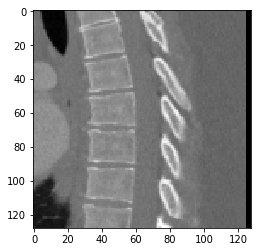

In [6]:
x = np.load(data_path.format('x') + filenames[0])
plt.imshow(x[:,:,60], cmap='gray')
x = np.reshape(x, (1, 128, 128, 128, -1))

(1, 128, 128, 128, 1)
1.3977369


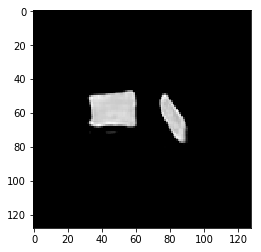

In [23]:
y = model.predict(x)
print(y.shape)
y = np.reshape(y, (128, 128, 128))
print(np.max(y))
plt.imshow(y[:,:,60], cmap='gray')

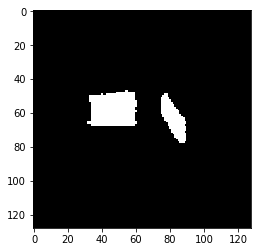

In [18]:
y = np.load(data_path.format('y') + filenames[0])
plt.imshow(y[:,:,60], cmap='gray')

In [4]:
model.load_weights('./save/model_weights.h5')